# Northwestern MOT Camera Setup
Camera parameters tbd, but geometry set by numbers in: https://docs.google.com/document/d/1gmqzoTKaecD3fDk6Jl7cKynLtw8270DmXRP-4g8IUmw/edit

8 possible camera positions. In the doc, X (1,2) + Y (3,4) correspond to the two diagonals, Z is the front (5)/back (6) of the chamber, right is right (7), pump is at the end of the long baseline (8).

![image](NW_MOT.png)

From the doc, parentheticals correspond to a range of possible camera distances away from the windows. To repeat distances:

Distance of the vacuum window outer faces from the center of the chamber
- X/Y/Right window: 12” (+ 3”-5” additional camera distance)
- Z: 4” (+5”-7” additional camera distance)
- Pump (left): 48”


In [1]:
import gradoptics as optics
from gradoptics.transforms.simple_transform import SimpleTransform
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

In [2]:
def inch_to_m(inch):
    # 1 in is 2.54 cm
    return 0.0254*inch

## Camera parameters
Somewhat tbd. For now let's just put in some filler f numbers (`f`), magnifications (`m`), numerical apertures (`na`). We do know the positions roughly -- let's define the coordinate system as (0, 0, 0) at the center of the MOT, with the x-axis along the pump/right window baseline (positive pointing right), z-axis vertical, y-axis in and out of the page (sorry that this doesn't correspond to the names, but it makes the most sense to me!).

We assume that the X/Y cameras (1,2,3,4) are tilted at a 45 degree angle from the x-axis, to be refined.

In [3]:
# Distances in m
camera_dist_x1 = inch_to_m(4.)
camera_dist_x2 = inch_to_m(4.)
camera_dist_y1 = inch_to_m(4.)
camera_dist_y2 = inch_to_m(4.)
camera_dist_z1 = inch_to_m(6.)
camera_dist_z2 = inch_to_m(6.)
camera_dist_right = inch_to_m(4)
camera_dist_pump = inch_to_m(0.)

x1_to_center = inch_to_m(12.)
x2_to_center = inch_to_m(12.)
y1_to_center = inch_to_m(12.)
y2_to_center = inch_to_m(12.)
right_to_center = inch_to_m(12.)
z1_to_center = inch_to_m(4.)
z2_to_center = inch_to_m(4.)
pump_to_center = inch_to_m(48.)

# Angle from positive x-axis
angle_x1 = np.radians(45.)
angle_x2 = np.radians(45.+180.)
angle_y1 = np.radians(-45.)
angle_y2 = np.radians(-45.+180)


camera_params = [
    {'name' : 'X_1', 
     'position' : ((x1_to_center+camera_dist_x1)*np.cos(angle_x1), 
                   0., (x1_to_center+camera_dist_x1)*np.sin(angle_x1)),
     'orientation' : (0, angle_x1+np.pi, 0),
     'f' : 35e-3,
     'na': 1/4.4, 
     'm' : 0.1},
    
    {'name' : 'X_2', 
     'position' : ((x2_to_center+camera_dist_x2)*np.cos(angle_x2), 
                   0., (x2_to_center+camera_dist_x2)*np.sin(angle_x2)),
     'orientation' : (0, angle_x2+np.pi, 0),
     'f' : 35e-3,
     'na': 1/4.4, 
     'm' : 0.1},
    
    {'name' : 'Y_1', 
     'position' : ((y1_to_center+camera_dist_y1)*np.cos(angle_y1),
                   0., (y1_to_center+camera_dist_y1)*np.sin(angle_y1)),
     'orientation' : (0, angle_y1+np.pi, 0),
     'f' : 35e-3,
     'na': 1/4.4, 
     'm' : 0.1},

    {'name' : 'Y_2', 
     'position' : ((y2_to_center+camera_dist_y2)*np.cos(angle_y2),
                   0., (y2_to_center+camera_dist_y2)*np.sin(angle_y2)),
     'orientation' : (0, angle_y2+np.pi, 0),
     'f' : 35e-3,
     'na': 1/4.4, 
     'm' : 0.1},
    
    {'name' : 'Z_1', 
     'position' : (0., (z1_to_center+camera_dist_z1), 0.),
     'orientation' : (0, 0, -np.pi/2),
     'f' : 35e-3,
     'na': 1/4.4, 
     'm' : 0.1},
    
    {'name' : 'Z_2', 
     'position' : (0., -(z2_to_center+camera_dist_z2), 0.),
     'orientation' : (0, 0, np.pi/2),
     'f' : 35e-3,
     'na': 1/4.4, 
     'm' : 0.1},
    
    {'name' : 'right', 
     'position' : ((right_to_center+camera_dist_right), 0., 0.),
     'orientation' : (0, 0, np.pi),
     'f' : 35e-3,
     'na': 1/4.4, 
     'm' : 0.1}, 
    
    {'name' : 'pump', 
     'position' : (-(pump_to_center+camera_dist_pump), 0., 0.),
     'orientation' : (0, 0, 0),
     'f' : 35e-3,
     'na': 1/4.4, 
     'm' : 0.1}
]

In [4]:
# Atom cloud
light_source = optics.LightSourceFromDistribution(optics.AtomCloud(phi=0.1, w0=0.01, 
                                                                   position=[0., 0., 0.]))

# Scene
scene = optics.Scene(light_source)

for camera in camera_params:
    transform = SimpleTransform(*camera['orientation'], camera['position'])
    lens = optics.PerfectLens(f=camera['f'], m=camera['m'], na=camera['na'],
                              position = camera['position'],
                              transform=transform)
                              
    rel_position = torch.tensor([-camera['f'] * (1 + camera['m']), 0, 0])                       
    rot_position = torch.matmul(transform.transform.float(), torch.cat((rel_position, torch.tensor([0]))))
    
    sensor_position = torch.tensor(camera['position']) + rot_position[:-1]
    viewing_direction = torch.matmul(transform.transform.float(), torch.tensor([1.,0,0,0]))
    
    sensor = optics.Sensor(position=sensor_position, viewing_direction=tuple(viewing_direction.numpy()),
                           resolution=(3000,3000))#, pixel_size=sensor_pixel_size,
                          # poisson_noise_mean=poisson_noise_mean, quantum_efficiency=quantum_efficiency)
    scene.add_object(sensor)
    scene.add_object(lens)

## Todo: add windows
Need to modify the `optics.Window` object a bit to allow for the possibility of rotation. Distances/orientations should be as given for cameras above, minus additional offsets. From the Google doc, other relevant info is:

Diameter of the windows:
- Pump: 5”
- Right window: 5”
- X/Y/Z: 2.69”

Thickness of the windows: 0.25 in

Refractive Index of the windows:
- 1.466691@Wavelength 435.957 nm
- 1.463123@Wavelength 486.269 nm

In [5]:
#left_interface_x_position = object_x_pos - .056
#right_interface_x_position = object_x_pos - .056 + stanford_thickness
#window1 = optics.Window(left_interface_x_position, right_interface_x_position, n_ext=1.000293, 
#                        n_glass=1.494, diameter=0.137)
#left_interface_x_position = object_x_pos + .056 - stanford_thickness
#right_interface_x_position = object_x_pos + .056
#window2 = optics.Window(left_interface_x_position, right_interface_x_position, n_ext=1.000293, 
#                        n_glass=1.494, diameter=0.137)

#scene.add_object(window1)
#scene.add_object(window2)

/sdf/group/magis/sgaz/sw/conda/envs/ml/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352660876/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


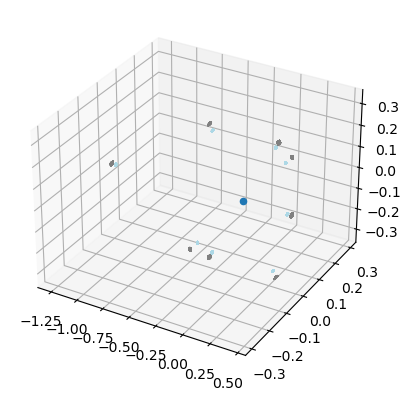

In [6]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
scene.plot(ax)

## Let's try simulating some images

We'll use backward ray tracing here, since that's what we'll use for a reconstruction. This samples rays at each pixel and traces them through the scene. A few key aspects:

- We need to define an integrator which tells us how to sample to integrate the contribution from the atomic density
- We need to define a bounding sphere which contains the atom cloud (defines where we do the integral)
- An implementation quirk -- we need to enclose the whole scene in a bounding sphere so that we don't have rays going off to infinity

In [7]:
# Define an integrator
from gradoptics.integrator import HierarchicalSamplingIntegrator
integrator = HierarchicalSamplingIntegrator(64, 64)

# Define a bounding shape to integrate in
scene.light_source.bounding_shape = optics.BoundingSphere(radii=0.03, 
                                                         xc=0, yc=0, zc=0)

# Enclose the scene in a large bounding sphere
scene.add_object(optics.BoundingSphere(xc=0, yc=0, zc=0, radii=10.))

In [8]:
pixel_batch = 200000
camera_intensities_all = []
for i,obj in enumerate(scene.objects):
    if type(obj) == optics.Sensor:
        sensor = scene.objects[i]
        lens = scene.objects[i+1]
        
        # Define pixel indices
        idxs = torch.cartesian_prod(torch.arange(sensor.resolution[0]//2, -sensor.resolution[0]//2, -1), 
                            torch.arange(sensor.resolution[1]//2, -sensor.resolution[1]//2, -1))

        pix_x, pix_y = idxs.T

        # Batch over them for rendering -- I used a large GPU
        batch_pix_x = pix_x.split(pixel_batch)
        batch_pix_y = pix_y.split(pixel_batch)

        intensities_all = []
        print(f"Rendering camera {camera_params[i//2]['name']}")
        for j in tqdm(range(len(batch_pix_x))):
            intensities_all.append(optics.ray_tracing.ray_tracing.render_pixels(sensor, 
                                                                               lens, 
                                                                               scene, scene.light_source, 1, 5, 
                                                                               batch_pix_x[j], batch_pix_y[j],
                                                                               integrator, device='cuda',max_iterations=3))

        camera_intensities = torch.cat(intensities_all).reshape(sensor.resolution)
        camera_intensities_all.append(camera_intensities.clone())

Rendering camera X_1


 44%|████▍     | 20/45 [00:11<00:07,  3.31it/s]/sdf/home/s/sgaz/gradoptics/src/gradoptics/optics/sensor.py:147: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ind // (self.resolution[1] * self.psf_ratio)] += luminosities[arg_ind, None]
100%|██████████| 45/45 [00:16<00:00,  2.67it/s]


Rendering camera X_2


100%|██████████| 45/45 [00:09<00:00,  4.81it/s]


Rendering camera Y_1


100%|██████████| 45/45 [00:09<00:00,  4.82it/s]


Rendering camera Y_2


100%|██████████| 45/45 [00:09<00:00,  4.75it/s]


Rendering camera Z_1


100%|██████████| 45/45 [00:15<00:00,  2.92it/s]


Rendering camera Z_2


100%|██████████| 45/45 [00:14<00:00,  3.15it/s]


Rendering camera right


100%|██████████| 45/45 [00:09<00:00,  4.80it/s]


Rendering camera pump


100%|██████████| 45/45 [00:06<00:00,  7.18it/s]


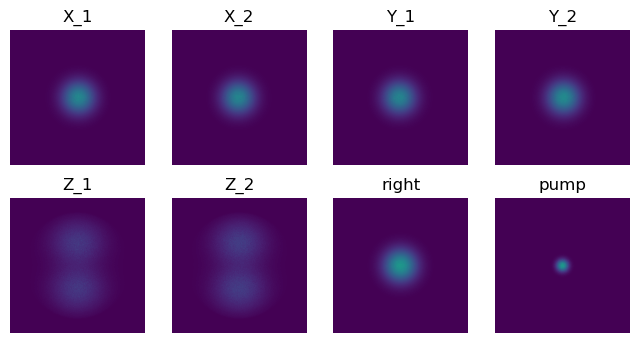

In [9]:
%matplotlib inline
fig, ax = plt.subplots(2,4, figsize=(8, 4))
for i in range(len(camera_intensities_all)):
    ax[i//4, i%4].imshow(camera_intensities_all[i].cpu())
    ax[i//4, i%4].set_title(f"{camera_params[i]['name']}")
    ax[i//4, i%4].axis('off')

## Just a quick plot to see what the pdf we're imaging is

In [10]:
n_side = 50
grid = torch.cartesian_prod(torch.linspace(-0.03, 0.03, n_side), 
                            torch.linspace(-0.03, 0.03, n_side),
                            torch.linspace(-0.03, 0.03, n_side))

In [11]:
pdf_vals = scene.light_source.distribution.pdf(grid).reshape((n_side,n_side,n_side))

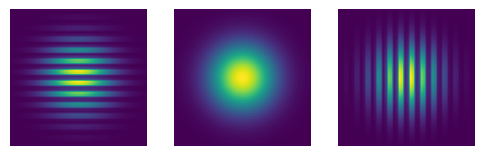

In [12]:
fig, ax = plt.subplots(1,3, figsize=(6, 2))
for i in range(3):
    ax[i].imshow(pdf_vals.sum(dim=i))
    ax[i].axis('off')